# Classification using random and Nyström features.

Author: <alberto.suarez@uam.es>

In this notebook we illustrate the use of random and Nystöm features with linear SVMs to carry out non-linear classification.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import kernel_approximation as ka

from sklearn import svm
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.kernel_approximation import RBFSampler
from sklearn import datasets

In [2]:
"""
# A simple 2 D problem
np.random.seed(0)
n_samples = 300
X = np.random.randn(n_samples, 2)
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
"""
# A not so simple 2 D problem
noise = 0.3

# Training set 
X, y = datasets.make_moons(n_samples=100, noise=noise, random_state=0)

# Test set 
X_test, y_test = datasets.make_moons(n_samples=1000, noise=noise)

# Compute grid of points for plotting the decision regions

grid_x1, grid_x2 = np.meshgrid(
    np.linspace(-3, 3, 50),
    np.linspace(-3, 3, 50),
)

grid_X = np.c_[grid_x1.ravel(), grid_x2.ravel()]

# Plot the decision regions 
def plot_decision_regions(X, y, grid_x1, grid_x2, features_grid, clf):

    # plot the decision function for each datapoint on the grid
    Z = clf.decision_function(features_grid)
    Z = Z.reshape(grid_x1.shape)


    plt.imshow(Z, interpolation='nearest',
    extent=(grid_x1.min(), grid_x1.max(), grid_x2.min(), grid_x2.max()), aspect='auto',
    origin='lower', cmap=plt.cm.PuOr_r)

    contours = plt.contour(grid_x1, grid_x2, Z, levels=[0], linewidths=2,
    linestyles='dashed')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired,
    edgecolors='k')
    plt.xticks(())
    plt.yticks(())
    plt.axis([np.min(grid_x1), np.max(grid_x1), np.min(grid_x2), np.max(grid_x2)])
    plt.show()

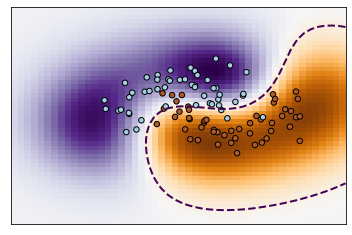

In [3]:
# Nonlinear SVM 

gamma = 0.5
sigma = np.sqrt(1.0 / 2.0 / gamma)

clf = svm.SVC(kernel='rbf', gamma=gamma)
# clf = svm.NuSVC(gamma=gamma)

clf.fit(X, y)

plot_decision_regions(X, y, grid_x1, grid_x2, grid_X, clf)

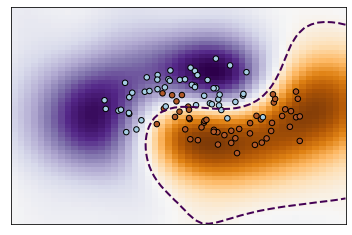

In [4]:
# RBF Fourier random features (sklearn)

n_random_features = 10000

rbf_sampler = RBFSampler(gamma=gamma, n_components=n_random_features, random_state=1)
random_features = rbf_sampler.fit_transform(X)
random_features_grid = rbf_sampler.fit_transform(grid_X)

clf = svm.SVC(kernel='linear')
# clf = svm.NuSVC(gamma='auto')

clf.fit(random_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, random_features_grid, clf)

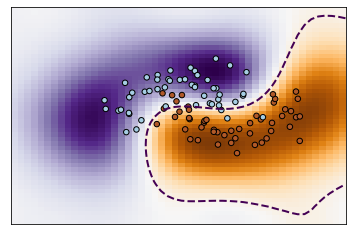

In [5]:
# RBF Fourier random features (our implementation)

rbf_sampler = ka.RandomFeaturesSamplerRBF(sigma)
random_features = rbf_sampler.fit_transform(n_random_features, X)
random_features_grid = rbf_sampler.transform(grid_X)

clf = svm.SVC(kernel='linear')
# clf = svm.NuSVC(gamma='auto')
clf.fit(random_features, y)


plot_decision_regions(X, y, grid_x1, grid_x2, random_features_grid, clf)

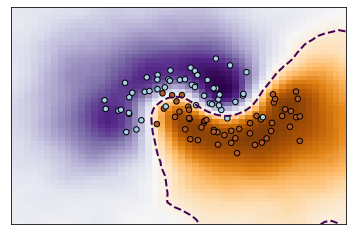

In [6]:
# Matérn Fourier random features (our implementation)
length_scale = sigma
nu = 1.5

matern_sampler = ka.RandomFeaturesSamplerMatern(length_scale, nu)    
random_features = matern_sampler.fit_transform(n_random_features, X)
random_features_grid = matern_sampler.transform(grid_X)

clf = svm.SVC(kernel='linear')
clf.fit(random_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, random_features_grid, clf)

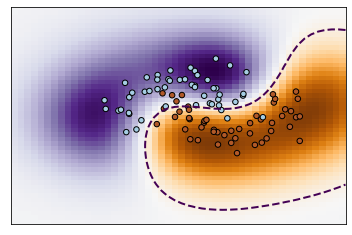

In [7]:
# Nystroem features (our implementation)

# Kernel matrix
def kernel(X, Y):
    return rbf_kernel(X, Y, gamma=gamma) 

n_nystroem_features = 20
# n_nystroem_features = len(X) # Recovers full kernel

nystroem_sampler = ka.NystroemFeaturesSampler(kernel)
nystroem_features = nystroem_sampler.fit_transform(n_nystroem_features, X)
nystroem_features_grid = nystroem_sampler.transform(grid_X)

clf = svm.SVC(kernel='linear')
clf.fit(nystroem_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, nystroem_features_grid, clf)

## Exercises

1. Afer having scaled the data to the range $[-1, 1]$ using sklearn's *MinMaxScaler*, determine the optimal hyperparameters (gamma, nu) and the optimal number of features for the different classifiers consideres in this example using CV on the training set. Compare the prediction error of the different classifiers in the test set $\left\{X_{test}, y_{test} \right\}$. 

References:
https://scikit-learn.org/stable/modules/preprocessing.html

https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py

